4.3.2 Gaussian Mixture Model anomaly detection
클러스터 형태의 비유연성 (원형)과 확률적 클러스터 할당 부재로 인해 K-Means는 부적절할 수 있음
가장 가까운 클러스터가 아닌 모든 클러스터와의 거리를 고려 - 클러스터 할당의 불확실성 (확률적)
클러스터 형태가 원형이 아닌 타원형이 될 수 있음
다차원 가우시안 확률 분포의 mixture
class sklearn.mixture.GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)[source]

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

최적 n_components 찾기
"""
    GMM은 generative 모델로 dataset에 대해 적정 components 수를 결정할 방법을 제공 
    확률 분포로 과적합 예방을 위해 교차 검증을 사용하여 데이터의 likelihood를 평가 가능
    Akaike information criterion (AIC) - 최소화 시 적정 컴포넌트 수
    Bayesian information criterion (BIC) - 보다 단순한 모델을 추천
    GMM 컴포넌트 수의 함수로 AIC 또는 BIC
"""

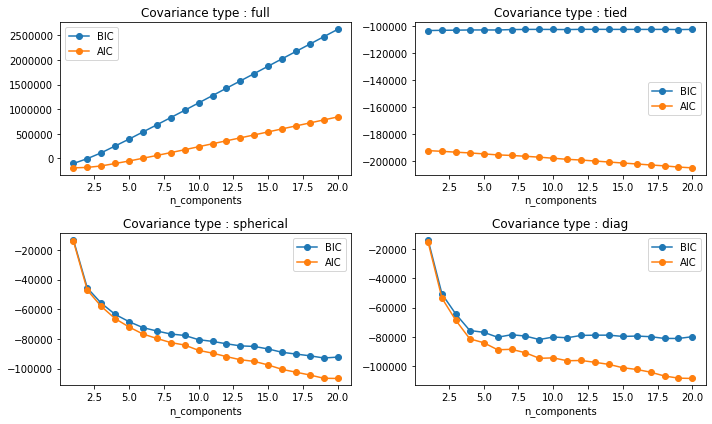

In [3]:
from sklearn.mixture import GaussianMixture
n_components = np.arange(1, 21)
covariance = ["full", "tied", "spherical", "diag"]

fig, axes = plt.subplots(2, 2, figsize=(10,6))
axes = axes.flatten()
for i, cov in enumerate(covariance):
    models = [ GaussianMixture(n, covariance_type=cov, random_state=1234, n_init=30, tol=0.001).fit(df[input_cols]) for n in n_components]
    axes[i].plot(n_components, [ m.bic(df[input_cols]) for m in models], label="BIC", marker="o")
    axes[i].plot(n_components, [ m.aic(df[input_cols]) for m in models], label="AIC", marker="o")
    axes[i].legend(loc="best")
    axes[i].set_xlabel("n_components")
    axes[i].set_title("Covariance type : " + str(cov))
plt.tight_layout()
plt.show()

GMM 모델

In [4]:
gmm = GaussianMixture(7, covariance_type="diag", random_state=1234, n_init=30, tol=0.001).fit(df[input_cols])

# weighted log probabilities for each sample
df["scores"] = gmm.score_samples(df[input_cols])
threshold_gmm = np.quantile(df["scores"], 0.1)

print("전력 사용이 의심되는 미터의 수 = " + str(len(df[["LP_METER_ID","scores"]][df["scores"] <= threshold_gmm])))
df[["LP_METER_ID","LP_DCU_ID","scores"]][df["scores"] <= threshold_gmm].sort_values("scores")

전력 사용이 의심되는 미터의 수 = 14


,LP_METER_ID,LP_DCU_ID,scores
89,99260000191,DCU_00DK94,-49.376831
61,99260000127,DCU_0DK242,-20.805847
22,99260000321,DCU_0TG312,16.578908
45,99260000345,DCU__TG70C,31.487332
90,99260000361,DCU__TG70C,48.013464
63,99260000268,DCU__TG70C,56.450695
77,99260000106,DCU_0TG312,66.517917
9,99260000336,DCU__TG70C,100.664420
87,99260000478,DCU_0DK242,136.091650
91,99260000022,DCU__TG70C,156.155793


GMM 기반 전력 사용 이상 미터 목록
gmm.predict_proba(df[input_cols]) - gmm 클러스터에 속할 확률

In [5]:
anomaly = df.loc[df["scores"] <= threshold_gmm]
anomaly_index_gmm = list(anomaly.index)
anomaly_id_list_gmm = df["LP_METER_ID"].iloc[anomaly_index_gmm].tolist()
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_gmm)

전력 사용이 의심되는 미터 목록
['99260000214', '99260000336', '99260000321', '99260000390', '99260000345', '99260000127', '99260000268', '99260000081', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361', '99260000022']


DCU 별 전력 사용 이상 미터 목록

In [6]:
meter_id_per_dcu = df[["LP_DCU_ID", "LP_METER_ID"]].iloc[anomaly_index_gmm].groupby("LP_DCU_ID")
print(meter_id_per_dcu["LP_METER_ID"].apply(list).index)
meter_id_per_dcu["LP_METER_ID"].apply(list).values

Index(['DCU_00DK94', 'DCU_0DK242', 'DCU_0TG312', 'DCU__TG70C'], dtype='object', name='LP_DCU_ID')


array([list(['99260000014', '99260000191']),
       list(['99260000390', '99260000127', '99260000478']),
       list(['99260000214', '99260000321', '99260000106']),
       list(['99260000336', '99260000345', '99260000268', '99260000081', '99260000361', '99260000022'])],
      dtype=object)

In [7]:
# GMM 클러스터 라벨
labels = gmm.fit_predict(df[input_cols])
cluster_labels = np.array(labels) 
cluster_labels

array([6, 5, 3, 0, 3, 6, 1, 2, 0, 5, 0, 3, 5, 2, 2, 4, 4, 6, 0, 2, 2, 0,
       5, 0, 4, 6, 0, 5, 6, 1, 0, 2, 5, 6, 2, 4, 4, 2, 4, 2, 6, 5, 5, 5,
       5, 4, 1, 2, 4, 6, 6, 2, 0, 6, 2, 2, 0, 4, 0, 5, 4, 4, 0, 3, 5, 5,
       6, 3, 2, 4, 2, 5, 6, 3, 0, 4, 0, 1, 4, 4, 1, 5, 4, 4, 3, 6, 4, 1,
       6, 1, 1, 2, 0, 6, 4, 0, 2, 6, 6, 5, 4, 6, 2, 5, 6, 6, 4, 3, 6, 5,
       5, 5, 5, 4, 6, 5, 6, 0, 0, 4, 3, 6, 0, 0, 4, 0, 6, 6, 0, 0, 0, 0,
       0, 0, 0])

GMM 데이터 시각화
anomaly_index_gmm

No handles with labels found to put in legend.


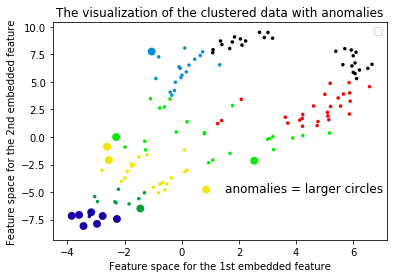

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D

n_clusters = 7

# t-SNE 비선형 임베딩 알고리즘
tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

# 데이터 포인트 플롯
plt.scatter(df_reduce[:135, 0], df_reduce[:135, 1], marker='.', s=50, lw=0, alpha=1, c=colors, edgecolor='k')

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_gmm, 0], df_reduce[anomaly_index_gmm, 1], marker='.', s=250, lw=0, alpha=1, c=colors[anomaly_index_gmm], edgecolor='k')

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
plt.legend()
plt.show()

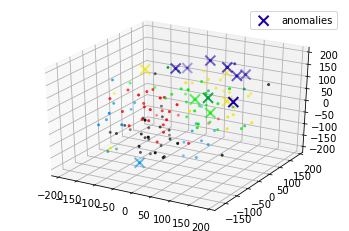

In [9]:
from mpl_toolkits.mplot3d import Axes3D
n_clusters = 7
tsne = TSNE(n_components=3, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_reduce[:, 0], df_reduce[:, 1], zs=df_reduce[:, 2], s=4, lw=1, c=colors)
ax.scatter(df_reduce[anomaly_index_gmm, 0], df_reduce[anomaly_index_gmm, 1], df_reduce[anomaly_index_gmm, 2],lw=2, s=100, marker="x", c=colors[anomaly_index_gmm], label="anomalies")
ax.legend()
plt.show()

4.3.3 DBSCAN anomaly detection
class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
eps와 min_samples 파라미터 조정 필요

In [ ]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 동일
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

두 인접 데이터 포인트 간 거리 및 인덱스

In [10]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[input_cols])
distances, indices = nbrs.kneighbors(df[input_cols])
print("두 인접 데이터 포인트 간 거리")
print(distances[:5])
print("두 인접 데이터 포인트 인덱스")
print(indices[:5])

두 인접 데이터 포인트 간 거리
[[0.         1.2526859 ]
 [0.         0.71125693]
 [0.         1.51639906]
 [0.         0.60136012]
 [0.         2.23459146]]
두 인접 데이터 포인트 인덱스
[[ 0  5]
 [ 1 59]
 [ 2 84]
 [ 3 21]
 [ 4  2]]


최적 eps

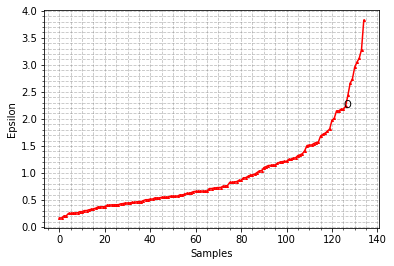

In [11]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[input_cols])

# 두 인접 데이터 포인트 간 거리와 이들의 인덱스
distances, indices = nbrs.kneighbors(df[input_cols])

# 데이터 포인트 간 거리를 오름차순으로 정렬
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, color="r", marker='^', markersize=2)
plt.text(125, 2.2, s='O', fontsize=10, color='black')
plt.ylabel("Epsilon")
plt.xlabel("Samples")
plt.grid(True, which="both", color='gray', alpha=0.5, linestyle='--')
#plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)
plt.minorticks_on()

최적 num_samples


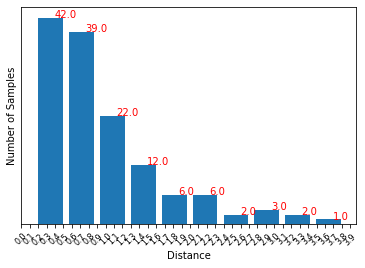

In [12]:
# 두 인접 데이터 포인트 간 거리에 대한 히스토그램
ys, xs, patches = plt.hist(distances, rwidth=0.8)
for i in range(0, len(ys)):
    plt.text(x=xs[i]+0.23, y=ys[i]+0.015, s='{}'.format(ys[i]), fontsize=10, color='red')
y_min, y_max = plt.ylim()
plt.ylim(y_min, y_max+0.05)
plt.xlabel("Distance")
plt.ylabel("Number of Samples")
plt.yticks([])
plt.xticks(np.arange(0, 4, step=0.1), ["{:.1f}".format(x) for x in np.arange(0, 4, step=0.1)], fontsize=8, rotation=45)
plt.show()

In [ ]:
DBSCAN 모델

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.2, min_samples=6)
df["anomaly"] = dbscan.fit_predict(df[input_cols])
print("전력 사용이 의심되는 미터의 수 = " + str(len(df[["LP_METER_ID","anomaly"]][df["anomaly"]==-1])))
df[["LP_METER_ID","anomaly"]][df["anomaly"]==-1]

전력 사용이 의심되는 미터의 수 = 13


,LP_METER_ID,anomaly
4,99260000364,-1
6,99260000214,-1
22,99260000321,-1
29,99260000390,-1
46,99260000322,-1
63,99260000268,-1
67,99260000147,-1
73,99260000188,-1
77,99260000106,-1
80,99260000014,-1


DBSCAN 기반 전력 사용 이상 미터 목록

In [14]:
anomaly = df.loc[df['anomaly']==-1]
anomaly_index_dbscan = list(anomaly.index)
anomaly_id_list_dbscan = df["LP_METER_ID"].iloc[anomaly_index_dbscan].tolist()
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_dbscan)

전력 사용이 의심되는 미터 목록
['99260000364', '99260000214', '99260000321', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']


DCU 별 전력 사용 이상 미터 목록

In [15]:
meter_id_per_dcu = df[["LP_DCU_ID", "LP_METER_ID"]].iloc[anomaly_index_dbscan].groupby("LP_DCU_ID")
print(meter_id_per_dcu["LP_METER_ID"].apply(list).index)
meter_id_per_dcu["LP_METER_ID"].apply(list).values

Index(['DCU_00DK94', 'DCU_0DK242', 'DCU_0TG312', 'DCU__TG70C'], dtype='object', name='LP_DCU_ID')


array([list(['99260000147', '99260000188', '99260000014', '99260000191']),
       list(['99260000364', '99260000390', '99260000478']),
       list(['99260000214', '99260000321', '99260000322', '99260000106']),
       list(['99260000268', '99260000361'])], dtype=object)

core 포인트와 border 포인트

In [16]:
core_points_index = dbscan.core_sample_indices_
border_points = df.loc[(df.index.isin(core_points_index)==False) & (df.index.isin(anomaly_index_dbscan)==False)]
border_points_index = np.array(border_points.index)

DBSCAN 데이터 시각화

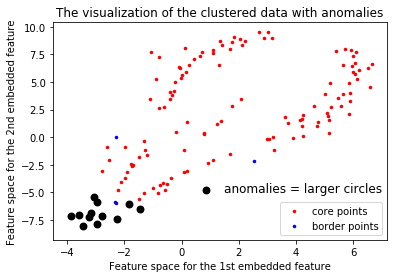

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 코어 데이터 포인트 플롯
plt.scatter(df_reduce[core_points_index, 0], df_reduce[core_points_index, 1], marker='.', s=50, lw=0, alpha=1,
            c="red", edgecolor='k', label="core points")

# 보더 데이터 포인트 플롯
plt.scatter(df_reduce[border_points_index, 0], df_reduce[border_points_index, 1], marker='.', s=50, lw=0, alpha=1,
            c="blue", edgecolor='k', label="border points")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_dbscan, 0], df_reduce[anomaly_index_dbscan, 1], marker='.', s=250, lw=0,
            alpha=1, c="k", edgecolor='k')

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
plt.legend()
plt.show()

4.3.4 Local Outlier Factor
주어진 인스턴스 주변의 인스턴스들의 density를 neighbors 주변의 density와 비교
Anomaly는 k-NN 보다 더욱 잘 isolated 됨
    
각 샘플의 로컬 density score를 계산하고 이들에 가중치를 부여하는 것이 기본 개념
샘플의 스코어를 neighbors들과 비교하여 anomalies가 존재하는 lower density elements를 정의
로컬 density는 k-nn에 의해 주어지며 이들과의 거리가 density 추정에 사용
로컬 density를 neighbors의 로컬 density와 비교함으로써 비슷한 density의 영역을 식별하고 보다 낮은 density를 갖는 데이터 포인트를 식별할 수 있음
class sklearn.neighbors.LocalOutlierFactor(n_neighbors=20, *, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', novelty=False, n_jobs=None)

In [ ]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 동일
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

In [18]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, algorithm="auto", contamination="auto")
df["anomaly"] = lof.fit_predict(df[input_cols])
print("전력 사용이 의심되는 미터의 수 = " + str(len(df[["LP_METER_ID","anomaly"]][df["anomaly"]==-1])))
df[["LP_METER_ID","anomaly"]][df["anomaly"]==-1]

전력 사용이 의심되는 미터의 수 = 7


,LP_METER_ID,anomaly
33,99260000143,-1
60,99260000333,-1
61,99260000127,-1
77,99260000106,-1
80,99260000014,-1
87,99260000478,-1
89,99260000191,-1


LOF 기반 전력 사용 이상 미터 목록

In [19]:
anomaly = df.loc[df['anomaly']==-1]
anomaly_index_lof = list(anomaly.index)
anomaly_id_list_lof = df["LP_METER_ID"].iloc[anomaly_index_lof].tolist()
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_lof)

전력 사용이 의심되는 미터 목록
['99260000143', '99260000333', '99260000127', '99260000106', '99260000014', '99260000478', '99260000191']


DCU 별 전력 사용 이상 미터 목록

In [20]:
meter_id_per_dcu = df[["LP_DCU_ID", "LP_METER_ID"]].iloc[anomaly_index_lof].groupby("LP_DCU_ID")
print(meter_id_per_dcu["LP_METER_ID"].apply(list).index)
meter_id_per_dcu["LP_METER_ID"].apply(list).values

Index(['DCU_00DK94', 'DCU_0DK242', 'DCU_0TG312'], dtype='object', name='LP_DCU_ID')


array([list(['99260000143', '99260000333', '99260000014', '99260000191']),
       list(['99260000127', '99260000478']), list(['99260000106'])],
      dtype=object)

LOF 데이터 시각화

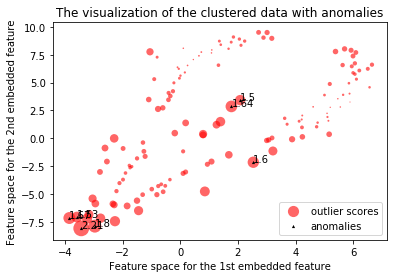

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 아웃 라이어 스코어에 비례한 데이터 포인트 플롯 
scores = lof.negative_outlier_factor_
radius = (scores.max() - scores) / ( scores.max() - scores.min())
plt.scatter(df_reduce[:, 0], df_reduce[:, 1], marker='.', s=1000*radius, lw=0, alpha=0.6, c="red", edgecolor='k', label="outlier scores")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_lof, 0], df_reduce[anomaly_index_lof, 1], marker='^', s=10, lw=0, alpha=1, c="black", edgecolor='k', label="anomalies")

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
#plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
n=np.copy(scores*-1)
n.sort()
threshold_score = n[-7:-6][0]
n=np.copy(scores*-1) # 스코어값은 음수
n[n<threshold_score]=np.nan # 스코어값이 threshold_score보다 작은 것은 미표시
n=np.round(n,2)
for i, txt in enumerate(n):
    if np.isnan(txt):continue
    plt.annotate(txt, (df_reduce[i, 0], df_reduce[i, 1]))
plt.legend()
plt.show()

4.4.3.1 Spark iForest anomaly detection
iForest Parameters, https://github.com/titicaca/spark-iforest

In [1]:
from pyspark_iforest.ml.iforest import *
from pyspark.sql.types import *
from pyspark.sql import functions as Fn
from pyspark.sql.functions import col, lit
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql import SparkSession
from sklearn.manifold import TSNE

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
#data = data.select(*(col(c).cast("float").alias(c) for c in data.columns))
#data.printSchema()

범주형 컬럼 특징 처리
Spark iForest는 현재 Dense Vector만 지원
VectorAssembler 결과는 Dense 또는 Sparse 일 수 있기 때문에 변환이 필요

In [2]:
from pyspark.ml.linalg import Vectors, VectorUDT
list_to_vector_udf = Fn.udf(lambda l: Vectors.dense(l), VectorUDT())

# DCU ID를 Integer 라벨로 변환
dcuIndexer = StringIndexer().setInputCol("LP_DCU_ID").setOutputCol("dcu_indexed")
dcuIndexed = dcuIndexer.fit(data).transform(data)

# Integer 라벨을 이진 벡터로 표현
encoder = OneHotEncoderEstimator().setInputCols(["dcu_indexed"]).setOutputCols(["dcu_enc"])
encoded = encoder.fit(dcuIndexed).transform(dcuIndexed)

inputCols = data.columns[2:]
inputCols.extend(["dcu_enc"])

assembler = VectorAssembler().setInputCols(inputCols).setOutputCol("features")
assembled = assembler.transform(encoded)
assembled = assembled.withColumn('vectorized_features', list_to_vector_udf("features"))
assembled = assembled.drop("features")
assembled = assembled.withColumn("features", col("vectorized_features")).drop("vectorized_features")

Spark iForest 모델
https://github.com/titicaca/spark-iforest
    maxFeatures : 각 트리를 학습하기 위해 데이터로부터 추출되는 특징의 수. maxFeatures <=1인 경우 totalFeatures, maxFeatures > 1인 경우 maxFeatures
    maxDepth : 트리 구축 시 사용하는 높이 제한. 기본 값은 log2(numSamples)
    numTrees : 트리 수
    maxSamples : 각 트리를 학습하기 위해 데이터로부터 추출되는 샘플의 수. maxSamples <=1인 경우 totalSamples, maxSamples > 1인 경우 maxSamples 
    contamination : 데이터셋 내 아웃라이어 비율 (0 ~ 1). anomaly 스코어를 예측된 라벨로 변환하기 위해 예측 단계에서만 사용. 성능 향상을 위해 anomaly 스코어 threshold를 얻는 방법은 approxQuantile에 의해 계산됨. 대규모 데이터셋에 대한 anomaly 스코어의 approxQuantile threshold를 계산하기 위해 approxQuantileRelativeError > 0 으로 설정
    approxQuantileRelativeError : 기본 0은 exact value를 계산 (대규모 데이터셋의 경우 expensive)
    bootstrap : true인 경우 개별 트리가 training data sampled with replacement의 임의 서브셋에 대해 fitting됨. 아닌 경우 sampling without replacement 수행
    seed
    featuresCol : 기본 features
    anomalyScoreCol : 기본 anomalyScore
    predictionCol : 기본 prediction
    여기서는 contamination을 설정하지 않음

In [3]:
seed = 1234
iForest = IForest().setMaxFeatures(1).setMaxSamples(1).setBootstrap(False).setSeed(seed).setNumTrees(100).setMaxDepth(50)
model = iForest.fit(assembled)
predictions = model.transform(assembled)
print("전력 사용이 의심되는 미터의 수 = " + str(model.summary.numAnomalies))
predictions.where(col("prediction") == "1").select("LP_METER_ID","LP_DCU_ID", "anomalyScore", "prediction").show(25)

전력 사용이 의심되는 미터의 수 = 13
+-----------+----------+------------------+----------+
|LP_METER_ID| LP_DCU_ID|      anomalyScore|prediction|
+-----------+----------+------------------+----------+
|99260000364|DCU_0DK242|0.5437092769993203|       1.0|
|99260000214|DCU_0TG312|0.5869388025639846|       1.0|
|99260000390|DCU_0DK242|0.5869091123939825|       1.0|
|99260000322|DCU_0TG312|0.6218104026533856|       1.0|
|99260000446|DCU__TG70C| 0.530128418629439|       1.0|
|99260000127|DCU_0DK242|0.5295738212752653|       1.0|
|99260000268|DCU__TG70C|0.5983879702101755|       1.0|
|99260000188|DCU_00DK94| 0.539036849270541|       1.0|
|99260000106|DCU_0TG312|0.6852519379546806|       1.0|
|99260000014|DCU_00DK94|0.6462359630168965|       1.0|
|99260000478|DCU_0DK242|0.6733886277970452|       1.0|
|99260000191|DCU_00DK94|0.7558530753770322|       1.0|
|99260000361|DCU__TG70C|0.6019873265554573|       1.0|
+-----------+----------+------------------+----------+



Spark iForest 기반 전력 사용 이상 미터 목록

In [4]:
anomaly_id = predictions.filter(col("prediction") == 1.0).select("LP_METER_ID")
anomaly_id_list_spark_if = [ row["LP_METER_ID"] for row in anomaly_id.collect()]
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_spark_if)

전력 사용이 의심되는 미터 목록
['99260000364', '99260000214', '99260000390', '99260000322', '99260000446', '99260000127', '99260000268', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']


DCU 별 전력 사용 이상 미터 목록

In [5]:
meter_id_per_dcu = predictions.where(col("prediction") == "1").select("LP_DCU_ID", "LP_METER_ID").groupBy("LP_DCU_ID")
meter_id_per_dcu.agg(Fn.collect_list("LP_METER_ID"), Fn.countDistinct("LP_METER_ID")).show(10, False)

+----------+----------------------------------------------------+---------------------------+
|LP_DCU_ID |collect_list(LP_METER_ID)                           |count(DISTINCT LP_METER_ID)|
+----------+----------------------------------------------------+---------------------------+
|DCU_0TG312|[99260000214, 99260000106, 99260000322]             |3                          |
|DCU_00DK94|[99260000191, 99260000014, 99260000188]             |3                          |
|DCU_0DK242|[99260000478, 99260000390, 99260000364, 99260000127]|4                          |
|DCU__TG70C|[99260000361, 99260000268, 99260000446]             |3                          |
+----------+----------------------------------------------------+---------------------------+



Spark 데이터 시각화

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np

df = data.toPandas()

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)
# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

anomaly = df.loc[ df.LP_METER_ID.isin(anomaly_id_list_spark_if) ]
anomaly_index_spark_if = list(anomaly.index)
anomaly_score = predictions.select("anomalyScore")
anomaly_scores = [ row["anomalyScore"] for row in anomaly_score.collect()]
anomaly_scores_spark_if = np.array(anomaly_scores)

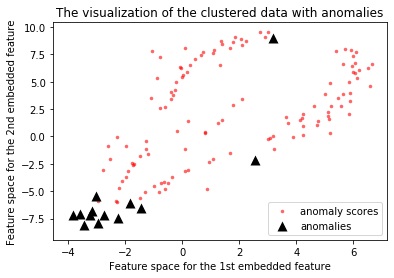

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 아웃 라이어 스코어에 비례한 데이터 포인트 플롯 
scores = anomaly_scores_spark_if
radius = (scores.max() - scores) / ( scores.max() - scores.min())
plt.scatter(df_reduce[:, 0], df_reduce[:, 1], marker='.', s=50, lw=0, alpha=0.6, c="red", edgecolor='k', label="anomaly scores")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_spark_if, 0], df_reduce[anomaly_index_spark_if, 1], marker='^', s=100, lw=0, alpha=1, c="black", edgecolor='k', label="anomalies")

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
#plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
n=np.copy(scores)
n.sort()
threshold_score = n[-13:-12][0]
n=np.copy(scores) # 스코어값은 음수
n[n<threshold_score] = np.nan # 스코어값이 threshold_score보다 작은 것은 미표시
n=np.round(n,2)
for i, txt in enumerate(n):
    if np.isnan(txt):continue
    #plt.annotate(txt, (df_reduce[i, 0], df_reduce[i, 1]))
plt.legend()
plt.show()

4.4.3.2 Scikit-learn Isolation Forest
Features에 대한 Scaling이 불필요
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
class sklearn.ensemble.IsolationForest(*, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, behaviour='deprecated', random_state=None, verbose=0, warm_start=False)

In [10]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 데이터 정규화 불필요
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

Scikit-learn Isolation Forest 모델

In [11]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, max_samples=1.0, contamination=0.0963, max_features=1.0,
                          random_state=1234)
iforest.fit(df[input_cols])

df["scores"] = iforest.decision_function(df[input_cols])
df["anomaly"] = iforest.predict(df[input_cols])
print("전력 사용이 의심되는 미터의 수 = " + str(len(df[["LP_METER_ID","scores","anomaly"]][df["anomaly"]==-1])))
df[["LP_METER_ID","LP_DCU_ID", "scores","anomaly"]][df["anomaly"]==-1].sort_values("scores")

전력 사용이 의심되는 미터의 수 = 13


,LP_METER_ID,LP_DCU_ID,scores,anomaly
89,99260000191,DCU_00DK94,-0.235992,-1
77,99260000106,DCU_0TG312,-0.144548,-1
87,99260000478,DCU_0DK242,-0.143928,-1
90,99260000361,DCU__TG70C,-0.093869,-1
80,99260000014,DCU_00DK94,-0.081543,-1
46,99260000322,DCU_0TG312,-0.066827,-1
29,99260000390,DCU_0DK242,-0.053753,-1
6,99260000214,DCU_0TG312,-0.042749,-1
73,99260000188,DCU_00DK94,-0.018100,-1
63,99260000268,DCU__TG70C,-0.014254,-1


Scikit-learn Isolation Forest 기반 전력 사용 이상 미터 목록

In [12]:
# 기본적으로 anomaly가 -1인 경우 anomalies
anomaly = df.loc[df['anomaly']==-1]
anomaly_index_sklearn_if = list(anomaly.index)
anomaly_id_list_sklearn_if = df["LP_METER_ID"].iloc[anomaly_index_sklearn_if].tolist()
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_sklearn_if)

전력 사용이 의심되는 미터 목록
['99260000214', '99260000321', '99260000390', '99260000322', '99260000127', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']


DCU 별 전력 사용 이상 미터 목록

In [13]:
meter_id_per_dcu = df[["LP_DCU_ID", "LP_METER_ID"]].iloc[anomaly_index_sklearn_if].groupby("LP_DCU_ID")
print(meter_id_per_dcu["LP_METER_ID"].apply(list).index)
meter_id_per_dcu["LP_METER_ID"].apply(list).values

Index(['DCU_00DK94', 'DCU_0DK242', 'DCU_0TG312', 'DCU__TG70C'], dtype='object', name='LP_DCU_ID')


array([list(['99260000147', '99260000188', '99260000014', '99260000191']),
       list(['99260000390', '99260000127', '99260000478']),
       list(['99260000214', '99260000321', '99260000322', '99260000106']),
       list(['99260000268', '99260000361'])], dtype=object)

Scikit-learn 데이터 시각화

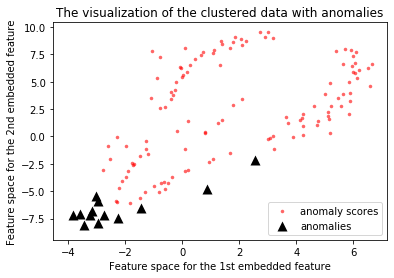

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# 시각화를 위해 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 아웃 라이어 스코어에 비례한 데이터 포인트 플롯 
df["scores"] = iforest.score_samples(df[input_cols])*-1
scores = df["scores"]
radius = (scores.max() - scores) / ( scores.max() - scores.min())
plt.scatter(df_reduce[:, 0], df_reduce[:, 1], marker='.', s=50, lw=0, alpha=0.6, c="red", edgecolor='k', label="anomaly scores")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_sklearn_if, 0], df_reduce[anomaly_index_sklearn_if, 1], marker='^', s=100, lw=0, alpha=1, c="black", edgecolor='k', label="anomalies")

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
#plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
n=np.copy(scores)
n.sort()
threshold_score = n[-13:-12][0]
n=np.copy(scores) # 스코어값은 음수
n[n<threshold_score] = np.nan # 스코어값이 threshold_score보다 작은 것은 미표시
n=np.round(n,2)
for i, txt in enumerate(n):
    if np.isnan(txt):continue
    #plt.annotate(txt, (df_reduce[i, 0], df_reduce[i, 1]))
plt.legend()
plt.show()

In [ ]:
트리 시각화

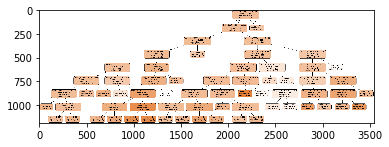

In [15]:
from sklearn.tree import export_graphviz
from graphviz import Source
import os

model = iforest.estimators_[70]
with open("/home/ambari/if-70.dot", 'w') as f:
    export_graphviz(model, out_file=f\
        , feature_names=input_cols, rounded=True, filled=True)
dot_path = "/home/ambari/if-70.dot"
output = Source.from_file(dot_path, format="png")
output.view()

import matplotlib.image
img = matplotlib.image.imread("/home/ambari/if-70.dot.png", 0)
plt.imshow(img)

4.5 오토인코더

In [16]:
import tensorflow.keras
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.callbacks import TensorBoard

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.manifold import TSNE

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib inline
import tensorflow 
import sys

오토인코더 시각화

In [17]:
labels = ["normal", "anomaly"]
# 실제 및 예측 라벨
def draw_confusion_matrix(y, ypred):
    matrix = confusion_matrix(y, ypred)
    plt.figure(figsize=(10, 8))
    colors=[ "orange","green"]
    #sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# reconstruction error에 따른 anomaly 
def draw_anomaly(y, error, threshold):
    groupsDF = pd.DataFrame({'error': error, 'true': y}).groupby('true')
    figure, axes = plt.subplots(figsize=(12, 8))
    for name, group in groupsDF:
        axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',\
            color='r' if name == 1 else 'g', label="anomaly" if name == 1 else "normal")
    axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
    axes.legend()
        
    plt.title("Anomalies")
    plt.ylabel("ReconstructionError")
    plt.xlabel("AMI Meter")
    plt.show()
    
# 데이터 포인트들의 reconstruction error
def draw_error(error, threshold):
    plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
    plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
    plt.legend()
    plt.title("Reconstruction error")
    plt.ylabel("Error")
    plt.xlabel("Data")
    plt.show()

In [18]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 동일
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

전력 사용 이상 미터 라벨링 - Isolation Forest (Spark & Scikit-learn) & DBSCAN NTL Results

In [19]:
print(anomaly_id_list_spark_if)
print(anomaly_id_list_sklearn_if)
print(anomaly_id_list_dbscan)

['99260000364', '99260000214', '99260000390', '99260000322', '99260000446', '99260000127', '99260000268', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
['99260000214', '99260000321', '99260000390', '99260000322', '99260000127', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']


In [21]:
anomaly_id_list_spark_if = ['99260000364', '99260000214', '99260000390', '99260000322', '99260000446', '99260000127', '99260000268', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
anomaly_id_list_sklearn_if = ['99260000214', '99260000321', '99260000390', '99260000322', '99260000127', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
anomaly_id_list_dbscan = ['99260000364', '99260000214', '99260000321', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000478', '99260000191', '99260000361']
anomaly_id_list = list(set(anomaly_id_list_spark_if + anomaly_id_list_sklearn_if + anomaly_id_list_dbscan))
y_anomalies = []
for id in df.LP_METER_ID.values.tolist():
    if id in anomaly_id_list:
        y_anomalies.append(1)
    else: y_anomalies.append(0)
df["anomalies"] = y_anomalies
df["LP_METER_ID"][df["anomalies"]==1]

4     99260000364
6     99260000214
22    99260000321
29    99260000390
46    99260000322
58    99260000446
61    99260000127
63    99260000268
67    99260000147
73    99260000188
77    99260000106
80    99260000014
87    99260000478
89    99260000191
90    99260000361
Name: LP_METER_ID, dtype: object

미터의 미터별 일별 사용량 + DCU ID 특징 데이터셋을 train 및 test로 분리
전력 사용 이상으로 라벨링된 df["anomalies"]를 향후 오토인코더 성능 평가에 활용

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df[input_cols], df["anomalies"], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(108, 246) train samples
(27, 246) test samples


In [23]:
딥 오토인코더 모델
tensorboard --logdir=/home/ambari/anomaly_detection/deepautoencoder

SyntaxError: invalid syntax (<ipython-input-23-941393b089a3>, line 1)

In [26]:
logfilename = "deepautoencoder"

encoding_dim = 28
input_dim = x_train.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputs)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)

decoded = Dense(encoding_dim // 2, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 246)]             0         
_________________________________________________________________
dense (Dense)                (None, 28)                6916      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 28)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 246)               7134  

In [27]:
autoencoder.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mae", "accuracy"])
batch_size = 16
epochs = 100
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, 
                          validation_split=0.1, callbacks=[TensorBoard(log_dir='/home/ambari/anomaly_detection/{0}'.format(logfilename))])

Train on 97 samples, validate on 11 samples
Epoch 1/100
97/97 [==============================] - 2s 22ms/sample - loss: 0.1104 - mae: 0.2584 - accuracy: 0.0000e+00 - val_loss: 0.0405 - val_mae: 0.1679 - val_accuracy: 0.0000e+00
Epoch 2/100
97/97 [==============================] - 0s 5ms/sample - loss: 0.1104 - mae: 0.2584 - accuracy: 0.0000e+00 - val_loss: 0.0405 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 3/100
97/97 [==============================] - 1s 5ms/sample - loss: 0.1104 - mae: 0.2583 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 4/100
97/97 [==============================] - 1s 8ms/sample - loss: 0.1103 - mae: 0.2583 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 5/100
97/97 [==============================] - 0s 5ms/sample - loss: 0.1103 - mae: 0.2583 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_mae: 0.1678 - val_accuracy: 0.0000e+00
Epoch 6/100
97/97 [=====================

97/97 [==============================] - 0s 800us/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8144 - val_loss: 0.0380 - val_mae: 0.1680 - val_accuracy: 0.9091
Epoch 93/100
97/97 [==============================] - 0s 1ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8144 - val_loss: 0.0382 - val_mae: 0.1683 - val_accuracy: 0.9091
Epoch 94/100
97/97 [==============================] - 0s 816us/sample - loss: 0.1084 - mae: 0.2585 - accuracy: 0.8247 - val_loss: 0.0379 - val_mae: 0.1679 - val_accuracy: 0.9091
Epoch 95/100
97/97 [==============================] - 0s 1ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8351 - val_loss: 0.0379 - val_mae: 0.1679 - val_accuracy: 0.9091
Epoch 96/100
97/97 [==============================] - 0s 2ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8351 - val_loss: 0.0379 - val_mae: 0.1679 - val_accuracy: 0.9091
Epoch 97/100
97/97 [==============================] - 0s 2ms/sample - loss: 0.1083 - mae: 0.2584 - accuracy: 0.8247 - val_loss: 0

테스트 데이터셋에 대한 평가, 데이터 수 관련 이슈

In [28]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])
print('Test accuracy:', score[2])

27/27 [==============================] - 0s 661us/sample - loss: 0.0904 - mae: 0.2466 - accuracy: 0.8889
Test loss: 0.090375155210495
Test mae: 0.24662791
Test accuracy: 0.8888889


특징 데이터셋을 예측하고 실제 값과 예측 값 간 reconstruction error 계산

In [29]:
y_pred = autoencoder.predict(df[input_cols])
y_dist = np.linalg.norm(df[input_cols] - y_pred, axis=-1)
y_dist.sort()
cut_point = int(0.89*len(y_dist))
threshold = y_dist[cut_point]
dist = np.linalg.norm(df[input_cols] - y_pred, axis=-1)

z = zip(dist >= threshold, dist)
y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
df['label'] = y_label
df[["LP_METER_ID", "LP_DCU_ID"]][df['label']==1]

,LP_METER_ID,LP_DCU_ID
2,99260000273,DCU__TG70C
4,99260000364,DCU_0DK242
6,99260000214,DCU_0TG312
11,99260000430,DCU_0DK242
29,99260000390,DCU_0DK242
46,99260000322,DCU_0TG312
63,99260000268,DCU__TG70C
67,99260000147,DCU_00DK94
73,99260000188,DCU_00DK94
77,99260000106,DCU_0TG312


재구성 에러 시각화

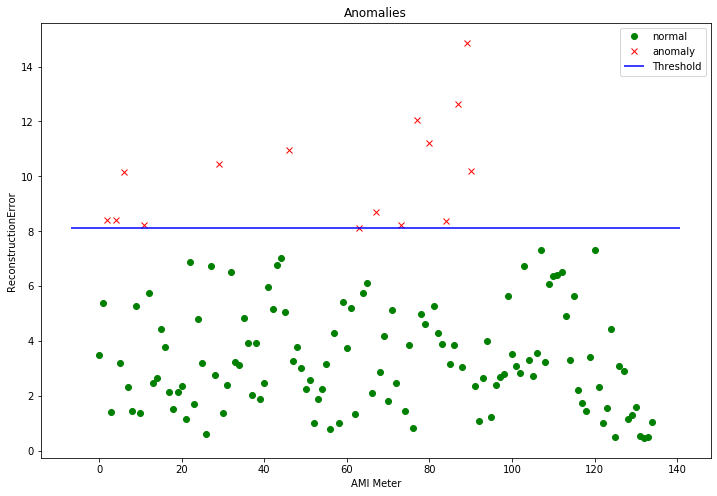

In [30]:
draw_anomaly(y_label, error, threshold)

오토인코더 기반 전력 사용 이상 미터 목록

In [31]:
anomaly = df.loc[df['label']==1]
anomaly_index_autoencoder = list(anomaly.index)
anomaly_id_list_autoencoder = df["LP_METER_ID"].iloc[anomaly_index_autoencoder].tolist()
print("전력 사용이 의심되는 미터 목록")
print(anomaly_id_list_autoencoder)

전력 사용이 의심되는 미터 목록
['99260000273', '99260000364', '99260000214', '99260000430', '99260000390', '99260000322', '99260000268', '99260000147', '99260000188', '99260000106', '99260000014', '99260000438', '99260000478', '99260000191', '99260000361']


DCU 별 전력 사용 이상 미터 목록

In [32]:
meter_id_per_dcu = df[["LP_DCU_ID", "LP_METER_ID"]].iloc[anomaly_index_autoencoder].groupby("LP_DCU_ID")
print(meter_id_per_dcu["LP_METER_ID"].apply(list).index)
meter_id_per_dcu["LP_METER_ID"].apply(list).values

Index(['DCU_00DK94', 'DCU_0DK242', 'DCU_0TG312', 'DCU__TG70C'], dtype='object', name='LP_DCU_ID')


array([list(['99260000147', '99260000188', '99260000014', '99260000191']),
       list(['99260000364', '99260000430', '99260000390', '99260000478']),
       list(['99260000214', '99260000322', '99260000106']),
       list(['99260000273', '99260000268', '99260000438', '99260000361'])],
      dtype=object)

딥 오토인코더 데이터 시각화

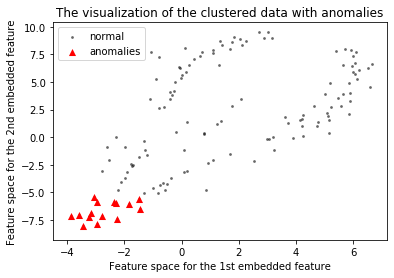

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])

# 정상 데이터 포인트 플롯 
plt.scatter(df_reduce[:, 0], df_reduce[:, 1], marker='.', s=30, lw=0, alpha=0.6, c="black", edgecolor='k', label="normal")

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_autoencoder, 0], df_reduce[anomaly_index_autoencoder, 1], marker='^', s=50, lw=0, alpha=1, c="red", edgecolor='k', label="anomalies")

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
plt.legend()
plt.show()

딥 오토인코더 분류 결과표

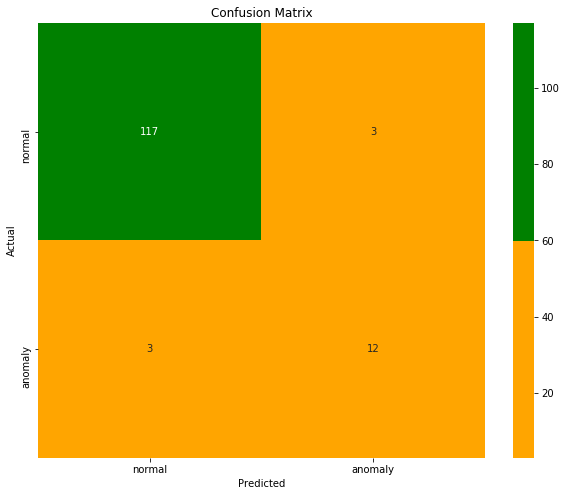

In [34]:
draw_confusion_matrix(df["anomalies"], df["label"])

딥 오토인코더 신경망의 평가 점수 - 탐지율 80%

In [35]:
print(classification_report(df["anomalies"], df["label"]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       120
           1       0.80      0.80      0.80        15

    accuracy                           0.96       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.96      0.96      0.96       135



ROC_AUC 스코어

In [36]:
print(roc_auc_score(df["anomalies"], df["label"]))

0.8875


In [ ]:
LSTMAutoEncoder, CnnLSTMAutoEncoder
LstmAutoEncoder 적용을 위해 특징 데이터셋에서 DCU ID 라벨 제외
STM 적용을 위한 (N_samples, time_steps, n_features)로 reshape. 여기서 n_features=1

In [37]:
# 특징 데이터셋과 범주형 컬럼 특징 처리 - 동일
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
df = data.toPandas()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

In [38]:
print(df.shape[0])
print(df.shape)
print(df[input_cols].shape[0])
print(df[input_cols].shape)
df[input_cols].head()

135
(135, 243)
135
(135, 241)


,daily_20191206,daily_20191207,daily_20191208,daily_20191209,daily_20191210,daily_20191211,daily_20191212,daily_20191213,daily_20191214,daily_20191215,...,daily_20200724,daily_20200725,daily_20200726,daily_20200727,daily_20200728,daily_20200729,daily_20200730,daily_20200731,daily_20200801,daily_20200802
0,0.173581,0.180371,0.229221,0.146944,0.223702,0.137285,0.090034,0.111764,0.212828,0.153309,...,0.256542,0.213749,0.276368,0.173305,0.233952,0.218244,0.246787,0.237103,0.231824,0.233857
1,0.320483,0.335652,0.331445,0.287414,0.345113,0.319003,0.350987,0.287922,0.328212,0.262786,...,0.292801,0.240570,0.305093,0.234544,0.262072,0.304490,0.329963,0.300830,0.308897,0.287858
2,0.479176,0.414791,0.389342,0.429026,0.464931,0.422391,0.397020,0.390728,0.413903,0.375034,...,0.593283,0.606125,0.628525,0.540157,0.638810,0.658548,0.687276,0.616764,0.600411,0.602426
3,0.089880,0.096254,0.111748,0.079158,0.091936,0.082466,0.083314,0.067893,0.101022,0.064544,...,0.006450,0.008589,0.013033,0.010010,0.011336,0.012359,0.013285,0.012307,0.012674,0.012318
4,0.453261,0.456337,0.449955,0.420141,0.379675,0.345034,0.447955,0.360674,0.468259,0.376395,...,0.636525,0.518455,0.567405,0.429091,0.520532,0.560587,0.609268,0.593026,0.641269,0.576248


In [39]:
df_numeric = df[input_cols]
df_numeric.head()
ts_df = np.expand_dims(df_numeric, axis=2)
ts_df.shape

(135, 241, 1)

In [40]:
# LSTM을 적용하기에는 데이터 수가 부족 (num_rows), 실제 적용하지는 않음
x_train, x_test = train_test_split(ts_df, test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(108, 241, 1) train samples
(27, 241, 1) test samples


In [43]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Dense, Flatten, MaxPooling1D

time_steps = df_numeric.shape[1]

# LstmAutoEncoder
# 241 features를 128, 64 및 32 units의 lstm 적용 후 241 /2, 241 dim으로 역순으로 복원
#model = Sequential()
#model.add(LSTM(units=128, input_shape=(time_steps,1), return_sequences=True))
#model.add(LSTM(units=64,return_sequences=True ))
#model.add(LSTM(units=32, return_sequences=False))
#model.add(Dense(units=time_steps // 2, activation='relu'))
#model.add(Dense(units=time_steps, activation='softmax'))

# CnnLSTMAutoEncoder, 병렬 연산 측면에서 Lstm AutoEncoder 대안
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',input_shape=(time_steps, 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dense(units=time_steps, activation='softmax')) 

model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=["mae", "accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 241, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_8 (Dense)              (None, 241)               15665     
Total params: 99,377
Trainable params: 99,377
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
logfilename = "lstmautoencoder"
batch_size = 8
epochs = 20 #

history = model.fit(ts_df, df_numeric, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False, validation_split=0.2,\
                callbacks=[TensorBoard(log_dir='/home/ambari/anomaly_detection/{0}'.format(logfilename))])